# Building the network II
This is a continuation of the previous work to avoid cluttering and because I was geeting some type of data overflow that I do not have time to repair right now

In [146]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set(font_scale=3.0)

In [147]:
def bernoulli_mask(size_from, size_to, p, binomial=True):
    if binomial:
        return np.random.binomial(n=1, p=p, size=(size_to, size_from))
    else:
        return np.random.choice(2, size=(size_to, size_from), replace=True, p=[1 - p, p])

In [148]:
def pre_synaptic_simple(epsilon, w, z_post, z_pre):
    increase = np.zeros_like(w)
    
    n = w.shape[0]
    for i in range(n):
        for j in range(n):
            increase[i, j] = z_pre[j] * z_post[i] - z_pre[j] * w[i, j]
    
    return epsilon * increase

def pre_synaptic(epsilon, w, z_post, z_pre):
    
    return epsilon * (np.outer(z_post, z_pre) - w * z_pre)

def post_synaptic(epsilon, w, z_post, z_pre):
    
    return epsilon * (np.outer(z_pre, z_post) - z_post * w)

In [149]:
def update_activity(k, z, x_i, c, weight, Is, Ir, s, m):
    inhibition = Is * s + Ir * m
    recurrent_excitation = np.dot(c * weight, z)
    input_excitation = k * x_i
    
    return input_excitation, recurrent_excitation, inhibition

In [150]:
def build_pattern_dictionary(number_of_patterns, sparsity, input_size):
    patterns_dictionary = {}
    for pattern_number in range(number_of_patterns):
        # Initialize the pattern with zero
        pattern = np.zeros(input_size)
        # Chose some indexes and set them to 1
        indexes = [pattern_number * sparsity + i for i in range(sparsity)]
        pattern[indexes] = 1
        # Creat the pattern entry in the dictionary
        patterns_dictionary[pattern_number] = pattern
        
    return patterns_dictionary

#### Excitation-Inhibition Balance

In [151]:
### Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0

# Training parameters
training_time = 100
epsilon = 0.1

# Patterns
number_of_patterns = 20
sparsity = 10
patterns_dictionary = build_pattern_dictionary(number_of_patterns, sparsity, n)

small_value = 0.1
w = np.ones((n, n)) * small_value 
# w = np.random.rand(n, n)
a = np.zeros((N, n))

m_history = []
w_history = []
input_excitation_history = []
inhibition_r_history = []
inhibition_out_history = []
excitation_r_history = []

c1 = bernoulli_mask(size_from=n, size_to=N, p=p, binomial=True)
c2 = bernoulli_mask(size_from=N, size_to=n, p=p, binomial=True)

c1 = np.ones((N, n))
c2 = np.ones((n, N))

In [152]:
sequence = [0, 1, 2, 3, 4, 5]
for _ in range(training_time):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
    
    for sequence_number in sequence:        
        # Input variables
        x = patterns_dictionary[sequence_number]       
        s = np.sum(x)
        modified_input = np.zeros(n)
        modified_input[np.where(x == 1)[0]] = 1.0
        

        # Update values for the C3
        input_excitation_r, recurrent_excitation_r, inhibition_r = update_activity(v, z_r, modified_input, c1, w, 
                                                                                   Ki, Kr, s, m)
        y_r =  input_excitation_r + recurrent_excitation_r - inhibition_r
        z_r_pre = np.copy(z_r)
        z_r = (y_r > theta).astype('float')


        # Update values for C1
        input_excitation_out, recurrent_excitation_out, inhibition_out = update_activity(b, z_r, x, c2, a, 
                                                                                         Ci, Cr, s, m)
        y_out = input_excitation_out + recurrent_excitation_out - inhibition_out 
        z_out = (y_out > phi).astype('float')

        # Update dynamical values
        m = np.sum(z_r)
        
        # Presynaptic rules
        w += pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        a += pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)
        # post-synaptic rules
        #w = post_synaptic(epislon=epislon, w=w, z_post=z_r, z_pre=z_r_pre)
        
        # History
        index = 0
        m_history.append(m)
        input_excitation_history.append(input_excitation_r[index])
        excitation_r_history.append(recurrent_excitation_r[index])
        w_history.append(w[11, 0])
        inhibition_r_history.append(inhibition_r)
        inhibition_out_history.append(inhibition_out)

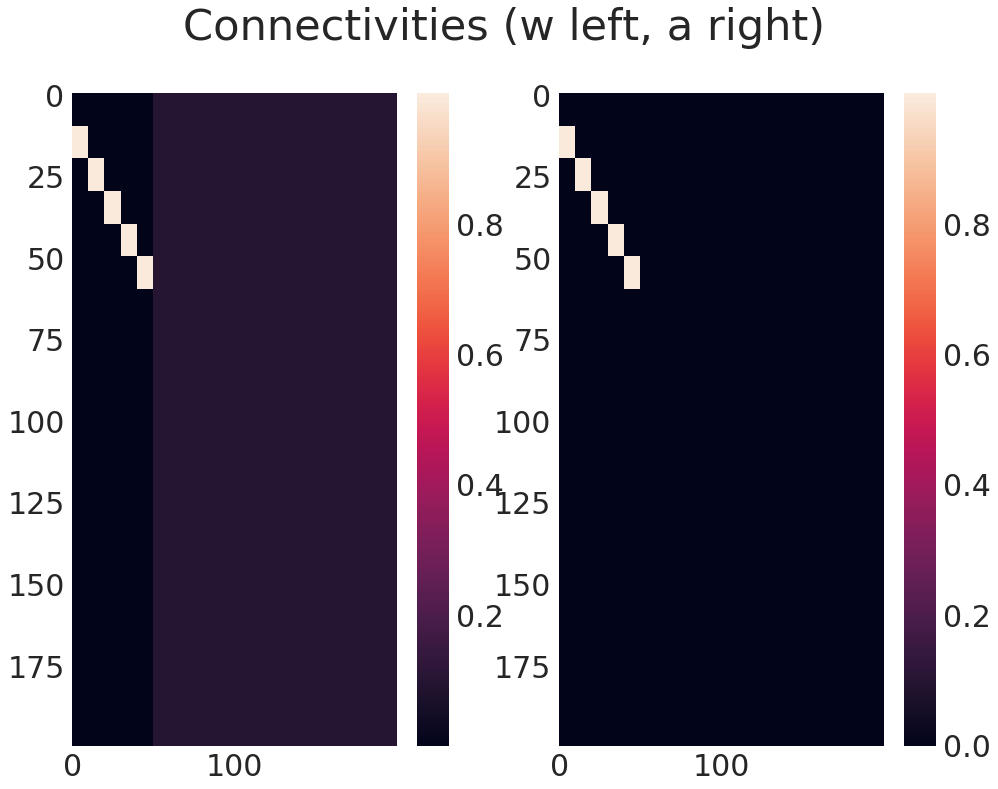

In [153]:
fig = plt.figure(figsize=(16, 12))

fig.suptitle('Connectivities (w left, a right)')

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(w, aspect='auto')
ax1.grid()

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(a, aspect='auto')
ax2.grid()

fig.colorbar(im1, ax=ax1);
fig.colorbar(im2, ax=ax2);

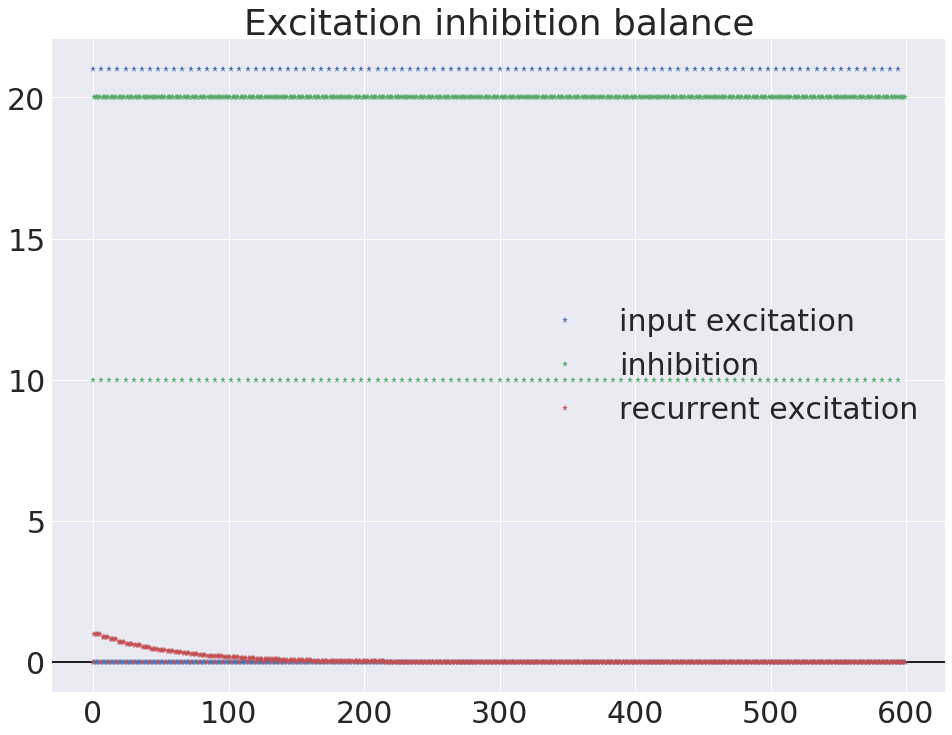

In [154]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(input_excitation_history, '*', label='input excitation')
ax.plot(inhibition_r_history, '*', label='inhibition')
ax.plot(excitation_r_history, '*', label='recurrent excitation')
ax.set_title('Excitation inhibition balance')


ax.legend();

In [160]:
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 0.1   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C

x = patterns_dictionary[0] 

m_history = []
w_history = []
input_excitation_history = []
inhibition_r_history = []
inhibition_out_history = []
excitation_r_history = []
recall_history = np.zeros((6, N))

# Initialize the variables
y_r = np.zeros(n)
z_r = np.zeros(n)
y_out = np.zeros(N)
z_out = np.zeros(N)
m = 0

verbose = True
for _ in range(6):
    s = np.sum(x)
    modified_input = np.zeros(n)
    modified_input[np.where(x == 1)[0]] = 1.0
    
    if verbose:
        print('------')
        print(_)
        print('----')
        print('s')
        print(s)
        print('m')
        print(m)

    # Update values for the C3
    input_excitation_r, recurrent_excitation_r, inhibition_r = update_activity(v, z_r, modified_input, c1, w, 
                                                                               Ki, Kr, s, m)
    y_r =  input_excitation_r + recurrent_excitation_r - inhibition_r
    z_r_pre = np.copy(z_r)
    z_r = (y_r > theta).astype('float')


    # Update values for C1
    input_excitation_out, recurrent_excitation_out, inhibition_out = update_activity(b, z_r, x, c2, a, Ci, Cr,
                                                                                    s, m)
    y_out = input_excitation_out + recurrent_excitation_out + inhibition_out
    z_out_pre = np.copy(z_out) 
    z_out = (y_out > phi).astype('float')

    # Update dynamical values
    m = np.sum(z_r)
    
    # History
    index = 0
    m_history.append(m)
    input_excitation_history.append(input_excitation_r[index])
    excitation_r_history.append(recurrent_excitation_r[index])
    inhibition_r_history.append(inhibition_r)
    inhibition_out_history.append(inhibition_out)
    recall_history[_, ...] = z_out
    # Eliminate the input
    x = np.zeros(n)
    
    if verbose:
        print('C3 layer')
        print('recurrent excitation')
        print(recurrent_excitation_r.astype('int'))
        print('---- inhibition')
        print(inhibition_r)
        print('excitation input')
        print(input_excitation_r)
        print('y_r')
        print(y_r)
        print('z_r')
        print(z_r)
        
        print('C1 layer')
        print('recurrent excitation_out')
        print(recurrent_excitation_out.astype('int'))
        print('inhibition_out')
        print(inhibition_r)
        print('excitation input_out')
        print(input_excitation_out)
        print('y_out')
        print(y_out)
        print('z_out')
        print(z_out)

------
0
----
s
10.0
m
0
C3 layer
recurrent excitation
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---- inhibition
10.0
excitation input
[ 21.  21.  21.  21.  21.  21.  21.  21.  21.  21.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0

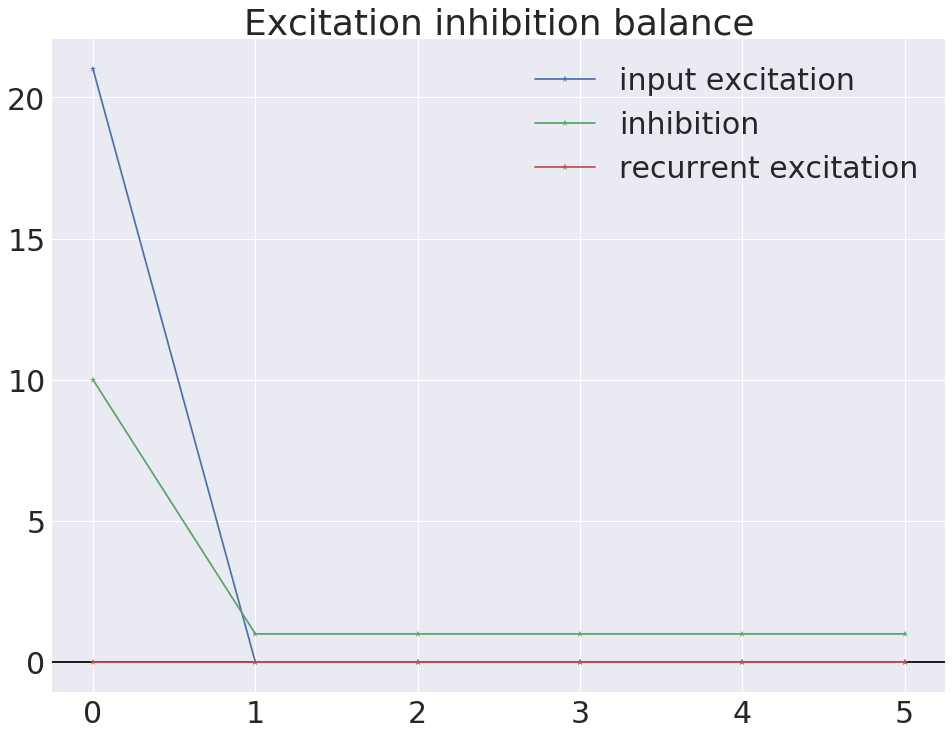

In [156]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(input_excitation_history, '-*', label='input excitation')
ax.plot(inhibition_r_history, '-*', label='inhibition')
ax.plot(excitation_r_history, '-*', label='recurrent excitation')
ax.set_title('Excitation inhibition balance')


ax.legend();

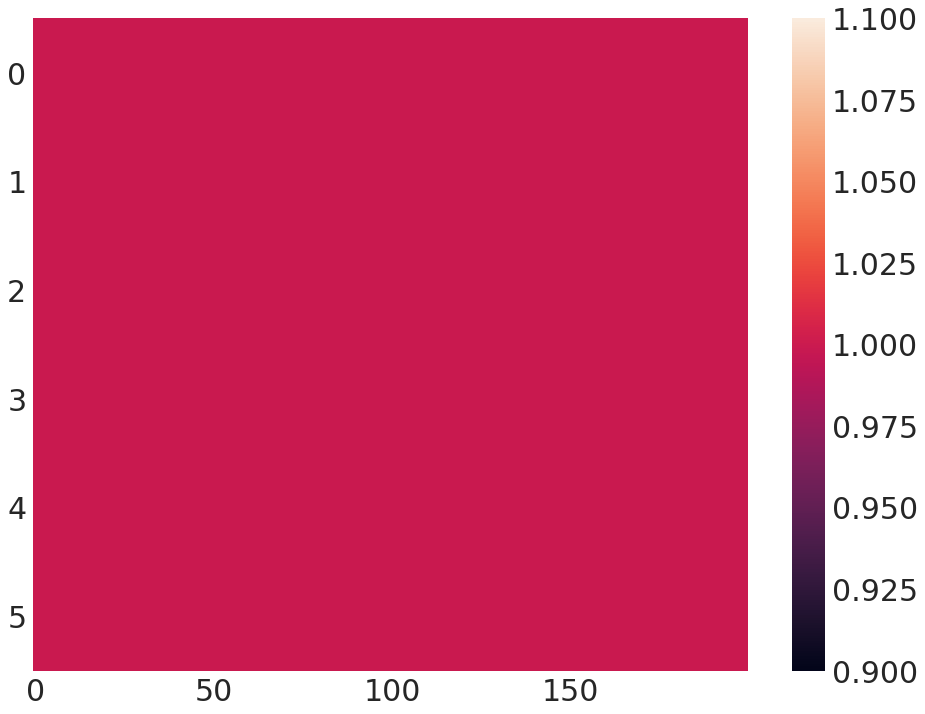

In [157]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(recall_history, aspect='auto')

ax.grid()

fig.colorbar(im, ax=ax)

In [158]:
recall_history

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])